# 2D ring resonator

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/RingResonator.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/RingResonator.ipynb), or just follow along with the output below.

This is a simple example of using Tidy3D to simulate a common photonics application.

We perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 1 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform each simulation in just a few minutes.

In [1]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# tidy3D import
import tidy3d as td
from tidy3d import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# resolution
dl = 0.012

# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

# set number of PMLs on each side
npml = 15

In [3]:
# define pulse parameters
pol = 'TE'  # 'TE' or 'TM'.  TE means waveguide excited Ey, TM means waveguide excited Ez
lambda_central = 0.5
f_center = td.C_0 /lambda_central
f_width =  f_center / 6
grids_per_wavelength = lambda_central / dl
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://simulation.cloud/docs/html/api.html#material)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(epsilon=n_bg**2)
solid = td.Medium(epsilon=n_solid**2)

Define structures. [(docs)](https://simulation.cloud/docs/html/api.html#structure)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Box(
    center=[0, 0, 0],
    size=[td.inf, td.inf, td.inf],
    material=background,
    name='background')

# waveguide
waveguide = td.Box(
    center=[0, wg_center_y, 0],
    size=[td.inf, wg_width, td.inf],
    material=solid,
    name='waveguide')

# outside ring
outer_ring = td.Cylinder(
    center=[0,0,0],
    axis='z',
    radius=ring_radius+ring_wg_width/2.0,
    height=td.inf,
    material=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Cylinder(
    center=[0,0,0],
    axis='z',
    radius=ring_radius-ring_wg_width/2.0,
    height=td.inf,
    material=background,
    name='inner_ring')

Define modal source. [(docs)](https://simulation.cloud/docs/html/api.html#source)

In [6]:
source = td.ModeSource(
    td.GaussianPulse(f_center, f_width, phase=0),
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
    direction='forward',
    amplitude=1.0,
    name='modal_source')

Define monitors. [(docs)](https://simulation.cloud/docs/html/api.html#monitor)

In [7]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FreqMonitor(
    center=[0, 0, 0],
    size=[x_span, y_span, 0],
    freqs=f_center,
    name='full_domain_fields')

# monitor the time series at a point in the center of the output waveguide
time_monitor = td.TimeMonitor(
    center=[wg_insert_x, wg_center_y, 0],
    size=[0, 0, 0],
    name='time_series')

Define simulation. [(docs)](https://simulation.cloud/docs/html/api.html#simulation)

Here, we turn off the automatic shutoff factor by setting it to 0. This is because we will compute the spectrum by a fourier transform of the time response, and we would like to run the normalization simulation and the simulation with ring to exactly the same `run_time`.

In [8]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 1*dl],
    mesh_step=[dl, dl, dl],
    structures=[background_box, waveguide],
    sources=[source],
    monitors=[field_monitor, time_monitor],
    run_time = run_time_norm,
    pml_layers=[npml, npml, 0])

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 1*dl],
    mesh_step=[dl, dl, dl],
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[source],
    monitors=[field_monitor, time_monitor],
    run_time = run_time,
    pml_layers=[npml, npml, 0])

Initializing simulation...
Mesh step (micron): [1.20e-02, 1.20e-02, 1.20e-02].
Simulation domain in number of grid points: [1280, 1013, 1].
Total number of computational grid points: 1.30e+06.
Total number of time steps: 4808.
Estimated data size (GB) of monitor full_domain_fields: 0.0590.
Estimated data size (GB) of monitor time_series: 0.0001.
Initializing simulation...
Mesh step (micron): [1.20e-02, 1.20e-02, 1.20e-02].
Simulation domain in number of grid points: [1280, 1013, 1].
Total number of computational grid points: 1.30e+06.
Total number of time steps: 240397.
Estimated data size (GB) of monitor full_domain_fields: 0.0590.
Estimated data size (GB) of monitor time_series: 0.0058.


----
Visualize structure, source, and modes. [(docs)](https://simulation.cloud/docs/html/api.html#plotting-tools)

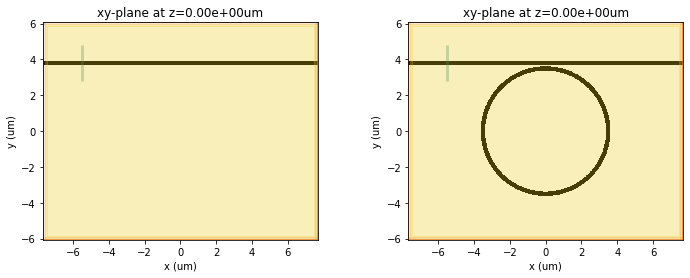

In [9]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sim0.viz_eps_2D(normal='z', position=0.0, ax=ax1)
sim.viz_eps_2D(normal='z', position=0.0, ax=ax2)
plt.show()

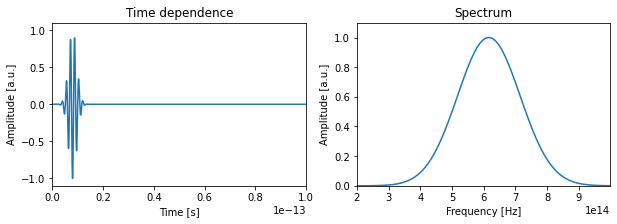

In [10]:
# visualize time series of source
ax1, ax2 = sim.viz_source(source)
ax1.set_xlim((0, 0.1e-12))  # note the pulse extends far beyond this time, adjust lims to inspect
plt.show()

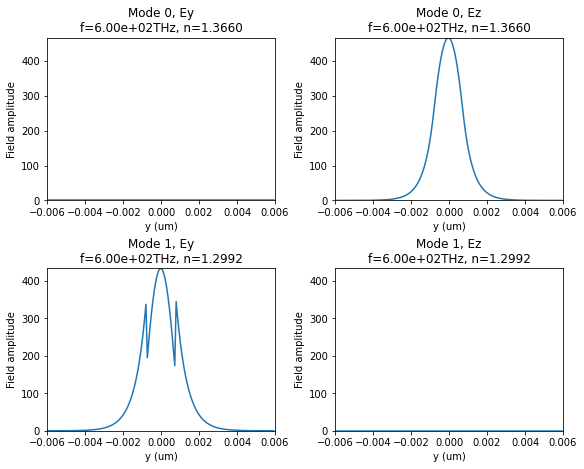

In [16]:
# Visualize the first two modes of the mode source
sim.compute_modes(source, Nmodes=2)
sim.viz_modes(source);

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

In [12]:
if pol == 'TM':
    mode_index = 0
elif pol == 'TE':
    mode_index = 1
else:
    raise ValueError('pol must be TM or TE')

# set the mode index of modal source in each sim
sim0.set_mode(source, mode_ind=mode_index)
sim.set_mode(source, mode_ind=mode_index)

Mode set, recommend verifying using viz_modes.
Mode set, recommend verifying using viz_modes.


----
## Run Simulation
Run simulations on our server. [(docs)](https://simulation.cloud/docs/html/api.html#web-api)

In [13]:
def run_tidy3d(sim, task_name=''):
    # Convenience function to run a simulation and download results
    
    # create a project, upload to our server to run
    project = web.new_project(sim.export(), task_name=task_name)
    task_id = project['taskId']
    web.monitor_project(task_id)

    # download the results and load into the original simulation
    print('downloading results...')
    web.download_results(task_id, target_folder='out')
    print('done\n')
    sim.load_results('out/monitor_data.hdf5')
    
    print('\n')

In [14]:
# use function above to run simulation with and without ring
run_tidy3d(sim0, task_name='normalization')
run_tidy3d(sim, task_name='with_ring')

Uploading the json file...
Project 'normalization-21' status: success...                                

downloading results...
done

Applying source normalization to all frequency monitors using source index 0.


Uploading the json file...
Project 'with_ring-12' status: success...                                

downloading results...
done

Applying source normalization to all frequency monitors using source index 0.




In [15]:
# which components of the electric field to plot, depending on polarization
if pol == 'TM':
    comps = ('z',)
elif pol == 'TE':
    comps = ('x', 'y')
else:
    raise ValueError('pol must be TM or TE')

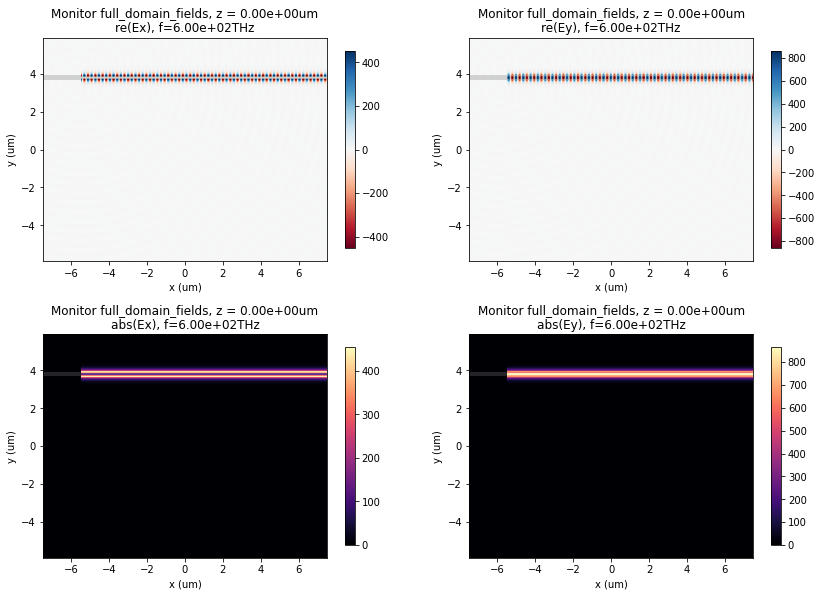

In [16]:
# visualize normalization run
fig, axes = plt.subplots(2, len(comps), figsize=(14, 10))
for axe, val in zip(axes.reshape(2, len(comps)), ('re', 'abs')):
    for ax, comp in zip(axe, comps):
        im = sim0.viz_field_2D(field_monitor, sample_ind=0, eps_alpha=0.15, comp=comp, val=val, cbar=True, ax=ax)

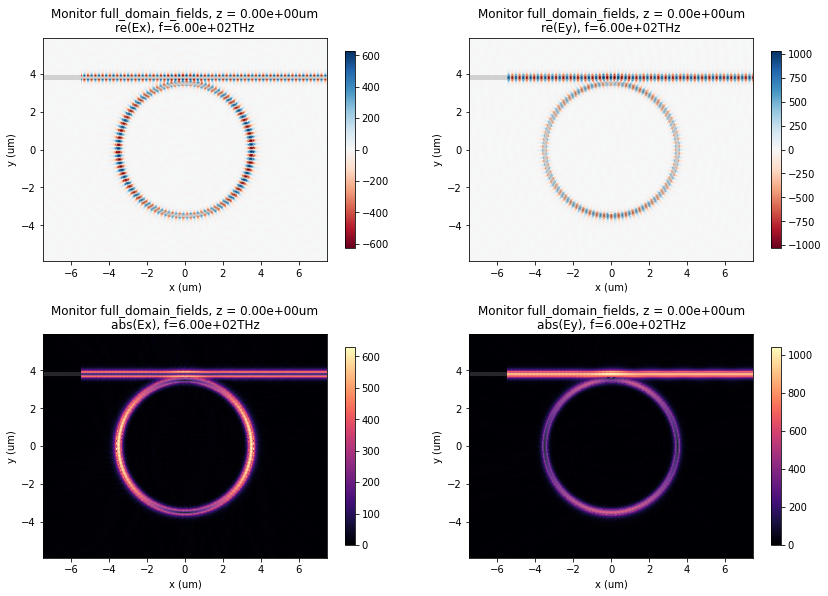

In [17]:
# visualize run with ring
fig, axes = plt.subplots(2, len(comps), figsize=(14, 10))
for axe, val in zip(axes.reshape(2, len(comps)), ('re', 'abs')):
    for ax, comp in zip(axe, comps):
        im = sim.viz_field_2D(field_monitor, sample_ind=0, eps_alpha=0.15, comp=comp, val=val, cbar=True, ax=ax)

## Analyze Spectrum
Analyze transmission spectrum using fourier transform. [(docs)](https://simulation.cloud/docs/html/api.html#miscellaneous)

In [18]:
# Get data from the TimeMonitor
tdata0 = sim0.data(time_monitor)
tdata = sim.data(time_monitor)
tmesh0 = tdata0["tmesh"]
tmesh = tdata["tmesh"]
Nt = tmesh.size
dt = tmesh[1] - tmesh[0]

# select output fields as Ez if TM or Ey if TE
field_index = 2 if pol == 'TM' else 1

E_out0 = tdata0['E'][field_index, 0, 0, 0, :]
E_out = tdata['E'][field_index, 0, 0, 0, :]

# frequencies to measure output spectrum at
freqs = td.C_0 / np.linspace(0.4, 0.6, 1000)

# fourier transform output time series to get spectrum at freqs
E_out0_f = td.dft_spectrum(E_out0, dt, freqs)
E_out_f = td.dft_spectrum(E_out, dt, freqs)

Plot results.

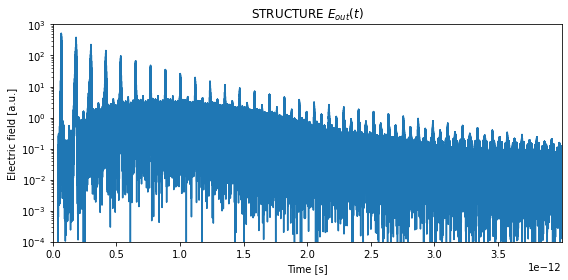

In [19]:
# plot time series with ring
fig, ax = plt.subplots(1, figsize=(8, 4), tight_layout=True)

ax.plot(tmesh, np.abs(E_out))
ax.set_xlabel("Time [s]")
ax.set_ylabel("Electric field [a.u.]");
ax.set_title("STRUCTURE $E_{out}(t)$")
ax.set_ylim((1e-4, 1e3))
ax.set_yscale('log')
ax.set_xlim((tmesh[0], tmesh[-1]));

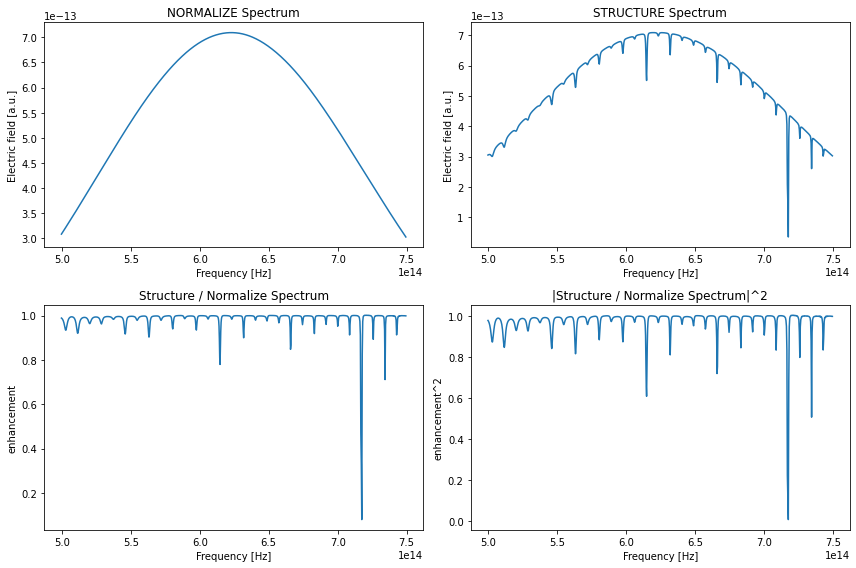

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

# plot spectrum of normalization (input)
ax[0, 0].plot(freqs, np.abs(E_out0_f))
ax[0, 0].set_xlabel("Frequency [Hz]")
ax[0, 0].set_ylabel("Electric field [a.u.]");
ax[0, 0].set_title("NORMALIZE Spectrum");

# plot transmission spectrum with ring
ax[0, 1].plot(freqs, np.abs(E_out_f))
ax[0, 1].set_xlabel("Frequency [Hz]")
ax[0, 1].set_ylabel("Electric field [a.u.]");
ax[0, 1].set_title("STRUCTURE Spectrum");

# plot spectrum ratio |E_ring(f)| / |E_norm(f)|
ax[1, 0].plot(freqs, np.abs(E_out_f) / np.abs(E_out0_f))
ax[1, 0].set_xlabel("Frequency [Hz]")
ax[1, 0].set_ylabel("enhancement");
ax[1, 0].set_title("Structure / Normalize Spectrum");

# plot square of spectrum ratio ( |E_ring(f)| / |E_norm(f)| )^2
ax[1, 1].plot(freqs, (np.abs(E_out_f) / np.abs(E_out0_f))**2)
ax[1, 1].set_xlabel("Frequency [Hz]")
ax[1, 1].set_ylabel("enhancement^2");
ax[1, 1].set_title("|Structure / Normalize Spectrum|^2");

In [21]:
# add your analysis here!